# _Compute seasonClim 2D for four seasons_
## Choose the kernel gloenv_py3.9
module load python/gloenv3.9

Ce _Jupyter Notebook_ a pour but d'aider des utilisateurs et utilisatrices du langage _NCL_ à la prise en main du langage _Python_.
Pour cela, il présente une manière possible d'effectuer via _Python_ les fonctions de scripts _NCL_.

## Import de librairies

Dans un premier temps, des librairies (_packages_) sont importées.

Comme certaines librairies sont utilisées très régulièrement dans les codes, il est de coutûme de leur donner un alias.
Par exemple, la librairie _numpy_ sera appelée via l'alias _np_.

In [1]:
import os
import time as tm
import numpy as np # une librairie utile pour les calculs numériques
import xarray as xr # une librairie utile pour gérer les données
from matplotlib import pyplot as plt # une librairie utile pour tracer des figures
import cartopy.crs as ccrs # une librairie utile pour tracer des cartes
import cartopy.feature as cfeature # une librairie utile pour tracer les continents, océans, et frontières

La communauté Python étant grande, on peut facilement trouver des fonctions et librairies adaptées aux besoins en tapant des mots clés sur son navigateur internet préféré.

Pour les grandes librairies (_numpy_, _scipy_, _matplotlib_, etc.), on peut trouver une documentation en ligne sur des pages dédiées.
On peut par exemple trouver des informations sur la librairie _xarray_ à l'adresse suivante : http://xarray.pydata.org/.

Afin d'augmenter la taille de la police pour toutes les figures, on peut placer cette commande tout au début du _Notebook_ :

In [2]:
plt.rcParams.update({'font.size': 20})

In [3]:
begin = tm.time()

## Initialisation

Dans les premiers blocs du _Notebook_, on renseigne les variables du codes.

In [4]:
varname = 'tos'   #'tos'
vartype = 'Omon' #! La variable nommée 'type' existe déjà dans Python, on ne souhaite pas la modifier.
model = 'CNRM-CM6-1'
expe = 'pa-pdSIC-ext' # pa-futArcSIC-ext pa-pdSIC-ext
grid = 'gn'

iyear = 2000
fyear = 2099

nbmonth = 12
month = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']

nbseason = 4
season = ['JFM', 'AMJ', 'JAS', 'OND']
#season = ['DJF','MAM','JJA','SON']

plot_type = 'png'

On spécifie les dossiers dans lesquelles on souhaite récupérer et écrire les données, ainsi que les noms des fichiers.

In [5]:
#indir = '/data/scratch/globc/dcom/CMIP6/PAMIP_CPL/CNRM-CERFACS/CNRM-CM6-1/CNRM-CM6-1_'+expe+'_r1i1p1f2/'
#infile = varname+'_'+vartype+'_'+model+'_'+expe+'_r1i1p1f2_'+grid+'_'+str(iyear)+'01'+'-'+str(fyear)+'12.nc'
indir = '/data/scratch/globc/coquart/DATA_FOR_COMMON_JUPYTER_NOTEBOOKS/'
infile = 'tos_Omon_CNRM-CM6-1_pa-pdSIC-ext_r1i1p1f2_gn_200001-209912.nc'
print(indir+infile)

/data/scratch/globc/coquart/DATA_FOR_COMMON_JUPYTER_NOTEBOOKS/tos_Omon_CNRM-CM6-1_pa-pdSIC-ext_r1i1p1f2_gn_200001-209912.nc


In [6]:
outdir = '../results/'
outfile = 'seasonClim_'+varname+'_'+expe+'_'+str(iyear)+'_'+str(fyear)+'.nc'


In [7]:
figdir = '../results/PLOTS/'
figfile = 'plot2D_seasonClim_'+varname+'_'+expe+'_'+str(iyear)+'_'+str(fyear)

Enfin, on peut définir des variables utiles dans le code.

In [8]:
nbyear = fyear - iyear + 1
print("Nombre d'années traitées :",nbyear)

Nombre d'années traitées : 100


## Transformation du fichier initial compute_seasonClim_2D.ncl

## Lecture des données

Pour ouvrir un fichier '.nc', on peut utiliser le package _xarray_.

In [9]:
f = xr.open_dataset(indir+infile, mask_and_scale = True)

On peut alors directement en extraire une variable via son nom :

In [10]:
time = f.time
time

<xarray.DataArray 'time' (time: 1200)>
array(['2000-01-16T12:00:00.000000000', '2000-02-15T12:00:00.000000000',
       '2000-03-16T12:00:00.000000000', ..., '2099-10-16T12:00:00.000000000',
       '2099-11-16T00:00:00.000000000', '2099-12-16T12:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 2000-01-16T12:00:00 ... 2099-12-16T12:00:00
Attributes:
    axis:           T
    standard_name:  time
    long_name:      Time axis
    time_origin:    1850-01-01 00:00:00
    bounds:         time_bounds

Ou bien l'obtenir via une variable nom :

In [11]:
var = f.get(varname)

Si on ne souhaite garder que les valeurs d'une certaine periode temporelle on utilise :

In [12]:
#var = var.sel(time = slice(str(iyear), str(fyear)))

Pour savoir ce que contient une variable, il suffit d'entrer son nom en dernière ligne d'un bloc de code, comme ceci :

In [13]:
var

<xarray.DataArray 'tos' (time: 1200, y: 294, x: 362)>
[127713600 values with dtype=float32]
Coordinates:
    lat      (y, x) float64 ...
    lon      (y, x) float64 ...
  * time     (time) datetime64[ns] 2000-01-16T12:00:00 ... 2099-12-16T12:00:00
Dimensions without coordinates: y, x
Attributes:
    standard_name:       sea_surface_temperature
    long_name:           Sea Surface Temperature
    units:               degC
    online_operation:    average
    cell_methods:        area: mean where sea time: mean
    interval_operation:  1800 s
    interval_write:      1 month
    description:         This may differ from "surface temperature" in region...
    history:             none
    cell_measures:       area: areacello

Dans le cas d'un _Dataset_ ou _DataArray_, le _Jupyter Notebook_ nous propose une vue interactive des données, avec le nom des dimensions, les coordonnées, ainsi que les attributs.

In [14]:
if grid == 'gn':
    c = xr.open_dataset(indir+'mask_NEMO.nc')
    msk = c.nogt_msk

ndim = msk.shape; y = ndim[0]; x = ndim[1];
print("x =",x)
print("y =",y)

x = 362
y = 294


## Calcul de la climatologie

Dans le bloc suivant, on va calculer la moyenne saisonnière et spatiale sur toutes les années, de sorte à avoir un tableau de dimensions (nbseason * y * x).

La librairie _xarray_ propose le calcul de la climatologie pour les saisons 'DJF', 'MAM', 'JJA', et 'SON' (_var.groupby('time.season')_).

Ici on souhaite une autre définition de saisons, on utilise donc une méthode alternative.

On commence par moyenner les données sur 3 mois.

On regroupe alors les données par mois, en sachant qu'ici il y a par exemple 1 donnée pour le mois de janvier, qui correspond en fait à la moyenne de janvier à mars.

On moyenne ensuite sur la dimension temporelle (toutes les années).

On modifie alors le nom de la dimension 'month' par 'season', qui est plus adapté à notre problème.
On en profite pour changer les coordonnées (pour l'instant les numéros des premiers mois des moyennes tri-mensuelles : 1, 4, 7, 10) par les lettres correspondantes.

Le tout à l'aide d'une seule ligne.

In [15]:
if nbseason == 4:
    print("dans la boucle")
    if season == ['DJF', 'MAM', 'JJA', 'SON']:
        var_clm_mean = var.groupby('time.season').mean(dim='time')
    elif season == ['JFM', 'AMJ', 'JAS', 'OND']:
        var_clm_mean = var.resample(time='3MS').mean(dim = 'time').groupby('time.month').mean(dim = 'time').rename({'month': 'season'}).assign_coords(season = season)
        
#var_clm_mean = var[30,:,:] # trace quelque chose
#var_clm_mean = var[1001,:,:] # ne trace rien

dans la boucle


## Écriture des données

In [16]:
ds = xr.Dataset({'seasonClim': var_clm_mean},
                attrs = {
                    'creation_date': tm.strftime('%d/%m/%Y'),
                    'script_name': 'compute_seasonClim_2D.ipynb',
                })
ds

<xarray.Dataset>
Dimensions:     (y: 294, x: 362, season: 4)
Coordinates:
    lat         (y, x) float64 ...
    lon         (y, x) float64 ...
  * season      (season) <U3 'JFM' 'AMJ' 'JAS' 'OND'
Dimensions without coordinates: y, x
Data variables:
    seasonClim  (season, y, x) float32 nan nan nan nan nan ... nan nan nan nan
Attributes:
    creation_date:  23/02/2022
    script_name:    compute_seasonClim_2D.ipynb

In [17]:

ds.to_netcdf(outdir+outfile)
print(outdir+outfile)

../results/seasonClim_tos_pa-pdSIC-ext_2000_2099.nc


# plot2D_seasonClim.ncl for four seasons

## Lecture des données

Cette fois-ci, étant donné qu'on souhaite connaître les données d'une seule variable d'un fichier, on peut utiliser une seule ligne pour lire ces données :

In [18]:
# seasonClim est la variable stockée dans le fichier seasonClimJFM_tos_pa-pdSIC-ext_2000_2099.nc
clim = xr.open_dataset(outdir+outfile, mask_and_scale = True).seasonClim
#clim = xr.open_dataset('/data/scratch/globc/ortega/NCL/SCRIPT_OUTPUTS/PAMIP/'+expe+'/'+outfile)
clim

<xarray.DataArray 'seasonClim' (season: 4, y: 294, x: 362)>
[425712 values with dtype=float32]
Coordinates:
    lat      (y, x) float64 ...
    lon      (y, x) float64 ...
  * season   (season) object 'JFM' 'AMJ' 'JAS' 'OND'
Dimensions without coordinates: y, x

NB : Ici, on recharge les données, ce qui n'est pas la peine quand on travaille dans un _Jupyter Notebook_.

In [19]:
if grid == 'gn':
    c = xr.open_dataset(indir+'mask_NEMO.nc')
    msk = c.nogt_msk
    d = xr.open_dataset(indir+'grid_NEMO.nc')
    lat = d.nogt_lat
    lon = d.nogt_lon

ndim = msk.shape; y = ndim[0]; x = ndim[1];
print("x =",x)
print("y =",y)

x = 362
y = 294


## Tracé des figures 

Pour tracer des données spatiales, plusieurs projections sont possibles sur le globe.
Ici, on choisit une projection stéréographique au Pôle Nord, en s'intéressant aux latitudes supérieures à 20N :

In [20]:
crs = ccrs.NorthPolarStereo()
minLat = 20.

Avant de tracer la figure, on définit différent paramètres graphiques en fonction de la variable d'intérêt :

In [21]:
if varname == 'tos':
    levels = np.arange(0, 20, 1)
    lbTitle = '(degC)'
elif varname == 'seasonClim':
    levels = np.arange(0, 20, 1)
    lbTitle = '(degC)'
elif varname == 'sos':
    levels = np.arange(14, 38, 1)
    lbTitle = '(g/kg)'
else:
    levels = None
    lbTitle = None

Il peut être utile de créer des fonctions, soit pour gagner en visibilité dans le code, soit pour répéter une opération sans recopier à chaque fois une suite de commandes.

Ici, les figures avec la projection stéréographique sont par défaut sous la forme de carrés.
On créé donc une fonction qui rogne la figure dans un cercle, comme suit :

In [22]:
def to_circle_plot(ax):
    """
    Cette fonction permet de rogner une figure dans un cercle.
    
    Parametres
    ----------
    ax : matplotlib.axes
        L'objet que l'on souhaite rogner.
    
    Retourne
    --------
    Rien
        L'objet 'ax' est modifié.

    """

    import numpy
    import matplotlib.path

    theta = np.linspace(0, 2 * numpy.pi, 100)
    center, radius = [0.5, 0.5], 0.5
    verts = numpy.vstack([numpy.sin(theta), numpy.cos(theta)]).T
    circle = matplotlib.path.Path(verts * radius + center)

    ax.set_boundary(circle, transform = ax.transAxes)

Dans un premier temps, on ne va tracer qu'une saison.

Voici les opérations correspondant aux lignes de commandes :
 - On créé l'objet figure, 'fig', ainsi qu'un objet qui contient les informations graphiques qui lui sont liées, 'ax'.
 - On précise la projection souhaitée ainsi que les latitudes et longitudes à tracer.
 - On active le tracé de la grille.
 - On force la figure à être tracée dans un cercle, via la fonction que l'on vient de définir.
 - On trace les données de la première saison (indice '0'), avec la palette de couleur 'jet'.
 - On active le tracé de la barre de légende en position horizontale (par conséquent, en bas de la figure), avec comme titre celui qui découle de la variable d'intérêt, défini quelques blocs plus haut.
 - On met un titre à la figure.

In [23]:
clim

<xarray.DataArray 'seasonClim' (season: 4, y: 294, x: 362)>
[425712 values with dtype=float32]
Coordinates:
    lat      (y, x) float64 ...
    lon      (y, x) float64 ...
  * season   (season) object 'JFM' 'AMJ' 'JAS' 'OND'
Dimensions without coordinates: y, x

On peut afficher les 4 saisons sur une même figure. Le code change alors légèrement.

Cette fois-ci, on sauvegarde la figure à la fin.

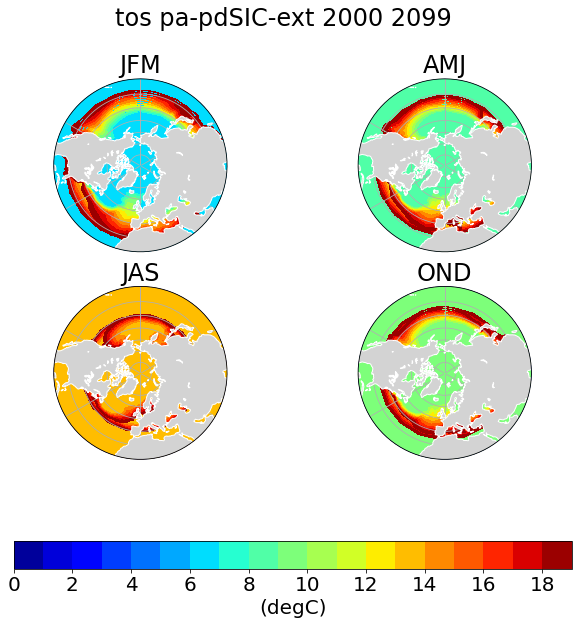

In [24]:
fig, axarr = plt.subplots(2, 2, figsize = (10, 10),
                          subplot_kw={'projection': crs})

axlist = axarr.flatten()

for i in range(nbseason):
    axlist[i].set_extent([-180, 180, minLat, 90], crs=ccrs.PlateCarree())

    axlist[i].add_feature(cfeature.LAND, zorder = 2, facecolor='lightgrey', edgecolor='w')
    axlist[i].add_feature(cfeature.LAKES, zorder = 2, facecolor='w')

    axlist[i].gridlines()

    to_circle_plot(axlist[i])

    cf = axlist[i].contourf(lon, lat, clim.sel(season=season[i]), levels, cmap = 'jet', transform=ccrs.PlateCarree())

    axlist[i].set_title(season[i])

cbar = fig.colorbar(cf, ax=axlist, orientation='horizontal')
cbar.set_label(lbTitle)

fig.suptitle(varname+' '+expe+' '+str(iyear)+' '+str(fyear))

plt.savefig(figdir+figfile+'.'+plot_type, transparent=True)

plt.show;

In [25]:
print('My work is done.')

My work is done.


In [26]:
end = tm.time()
print('Runtime of the program is', '{0:.1f}'.format(end - begin), 's')

Runtime of the program is 14.1 s
